# Congenital Central Hypoventilation syndrome ("Ondine syndrome") from an existing network

This notebook assumes that you have read **NORDic Network Identification (NI) Part I**. We consider here **NORDic version 2.2.1**.

## Installation

In [1]:
import NORDic

## Parameters for NORDic (from Part I)

In [2]:
file_folder="MODELS/Ondine_existing_network/" ## the folder name is changed

Refer to Part I for further details.

In [3]:
## Registration to databases
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"
STRING_credentials = "../tests/credentials_STRING.txt"
LINCS_credentials = "../tests/credentials_LINCS.txt"

## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2)
taxon_id=9606 # human species
disease_cids=["C1275808"] 
cell_lines=["NPC", "SHSY5Y"]

## Information about the disease
DISGENET_args = {
        "credentials": DisGeNET_credentials, "disease_cids": disease_cids,
}

## Selection of parameters relative to the prior knowledge network 
STRING_args = {
        "credentials": STRING_credentials, "score": 0,
}
EDGE_args = {
        "tau": 0, "filter": True, "connected": True, 
}

accept_nonRNA=True

## Selection of parameters relative to experimental constraints
LINCS_args = {
        "path_to_lincs": "../lincs/", "credentials": LINCS_credentials,
        "cell_lines": cell_lines, "thres_iscale": None,
}
SIG_args = {
        "bin_thres": 0.5,
}

force_experiments=False

## Selection of parameters relative to the inference of networks
BONESIS_args = {
        "limit": 1, "exact": True, "max_maxclause": 3,
}

## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

## Using an existing network in NORDic

The network inferred in **NORDic Network Identification (NI) Part I** might not be very interesting, due to the small number of genes. **NORDic** allows feeding an existing network to the network identification pipeline, which means that the set of genes and/or a putative prior knowledge network are provided to the pipeline.

Since version 2.2.3, **NORDic** may infer the sign of the edges in the prior knowledge network using the gene expression data retrieved from **LINCS L1000**, instead of using the sign of the edge-related scores in the network stored at "network_fname", by setting option *preserve_network_sign* to **False**. The default behavior is *preserve_network_sign=* **True**, and is consistent with the behavior of past versions of **NORDic**.

In [4]:
preserve_network_sign=True

### A. Structure of an input network to **NORDic**

Any network in input to **NORDic** is a table where each row corresponds to a single edge, with 5 columns:
- "preferredName_A" name of the input node in the edge
- "preferredName_B" name of the output node
- "sign" sign of the interaction (activatory: 1, inhibitory: -1, non monotonous: 2)
- "directed" is that edge directed from A to B? (0: undirected, 1: directed)
- "score" confidence score assigned to that edge

In this example, we will retrieve a set of protein actions involving genes from the previous network, from the STRING databases, using function *get_interactions_from_STRING*, that will automatically convert that set of interactions into a proper network for **NORDic**. In particular, it will add all genes which are connected to the set of genes in the previous network.

In [5]:
from NORDic.UTILS.STRING_utils import get_interactions_from_STRING

with open("MODELS/Ondine/solution.bnet", "r") as f:
    gene_list = [s.split(" <- ")[0] for s in f.read().split("\n")]
gene_list

['ASCL1', 'BDNF', 'EDN3', 'GDNF', 'PHOX2B']

In [6]:
from subprocess import call as sbcall
sbcall("mkdir -p "+file_folder, shell=True)

## Get physical interactions from the STRING database involving the list of genes in input
PPI = get_interactions_from_STRING(gene_list, taxon_id,
                                   min_score=0, app_name="NORDic_packagePartII",
                                   file_folder=file_folder)

## Save the corresponding network into a CSV file
NETWORK_fname = file_folder+"full_PPI.tsv"
PPI.to_csv(NETWORK_fname, sep="\t", index=None)

PPI

<STRING> Retrieving the file from STRING... Saved at MODELS/Ondine_existing_network/protein_action.tsv
<STRING> Getting the STRING name mapping for genes
<STRING> Getting the STRING name mapping for genes


,preferredName_A,preferredName_B,sign,directed,score
0,CX3CL1,BDNF,1,1,0.416
1,RANBP9,BDNF,2,0,0.416
2,UTS2,EDN3,2,1,0.902
4,GNA11,EDN3,2,1,0.900
5,GNA11,EDN3,2,0,0.900
...,...,...,...,...,...
1872,NTRK2,BDNF,1,0,0.814
1925,NTRK1,BDNF,1,0,0.800
1929,EDN3,CASR,2,0,0.905
1935,BDNF,NTRK1,1,0,0.800


### B. Parameter finetuning

In [7]:
## "filter" is set to False, meaning that we do not filter out edges by correlation
EDGE_args.update({"tau": 0, "filter": False, "connected": True})

## "thres_iscale" is set to 0.05, meaning that experiments must have a corresponding
## interference scale score strictly higher than 0.05
LINCS_args.update({"thres_iscale": 0.05})

## Binarization threshold is set to 0.13
SIG_args.update({"bin_thres": 0.13})

## NORDic must enumerate at most 100 models (limit=100)
## which may use a subset of interactions from the prior knowledge network (exact=False)
## where the maximum number of disjunctive clauses is 10
BONESIS_args.update({"limit": 100, "exact": False, "max_maxclause": 3})

## No gene set is given
path_to_genes=None

## We use the PPI computed above
NETWORK_fname = file_folder+"full_PPI.tsv"

### C. Network identification using an existing network

In [8]:
from NORDic.NORDic_NI.functions import network_identification

larger_network_full = NORDic.NORDic_NI.functions.network_identification(file_folder, 
            taxon_id, path_to_genes=path_to_genes, disgenet_args=DISGENET_args, 
            string_args=STRING_args, lincs_args=LINCS_args,
            edge_args=EDGE_args, sig_args=SIG_args,
            bonesis_args=BONESIS_args, weights=DESIRABILITY,
            seed=seed_number, network_fname=NETWORK_fname, njobs=njobs, 
            force_experiments=force_experiments, accept_nonRNA=accept_nonRNA,
            preserve_network_sign=preserve_network_sign)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... ... 342 genes imported.
2. Import network from MODELS/Ondine_existing_network/full_PPI.tsv... ... 771 edges in model (including 503 directed edges) with a total of 342 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines are considered (['NPC', 'SHSY5Y'])
	342 genes available (convertable to EntrezIDs)
		340/342 genes retrieved in LINCS L1000
... 285 genes in 101 profiles (14 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 771 unique edges involving genes both in experiments (342 genes in total)
... score_STRING 0.000000	342 genes (non isolated in PPI)	985 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 13 negative, 532 positive undirected interactions (545 edges in total), 342 non isolated genes in experiments
3. Build dynamical constraints by binarization of

  0%|                                                                                                  | 0/1 [00:00<?, ?it/s]

Grounding...done in 4.7s
Found 100 solutions in 113.6s (first in 5.7s; rate 1.1s)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:59<00:00, 119.43s/it]


--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...100 solutions (100 unique solutions)
... 100 solutions (314/343 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 29 edges
<MODEL VISUALIZATION> Maximal solution: 302 edges
          1         2         3         4         5         6         7    \
GTP  0.748355  0.748934  0.750625  0.748596  0.752093  0.847974  0.748445   

          8         9         10        11        12        13        14   \
GTP  0.750754  0.748569  0.748928  0.751061  0.748452  0.746713  0.750625   

         15        16        17        18       19        20        21   \
GTP  0.75021  0.746713  0.829916  0.748596  0.73597  0.748928  0.734586   

          22        23        24       25        26        27        28   \
GTP  0.752584  0.818271  0.748569  0.75021  0.748445  0.749161  0.748569   

          29        30        31        32        33        34        35   \
GTP  0.734586  0.7

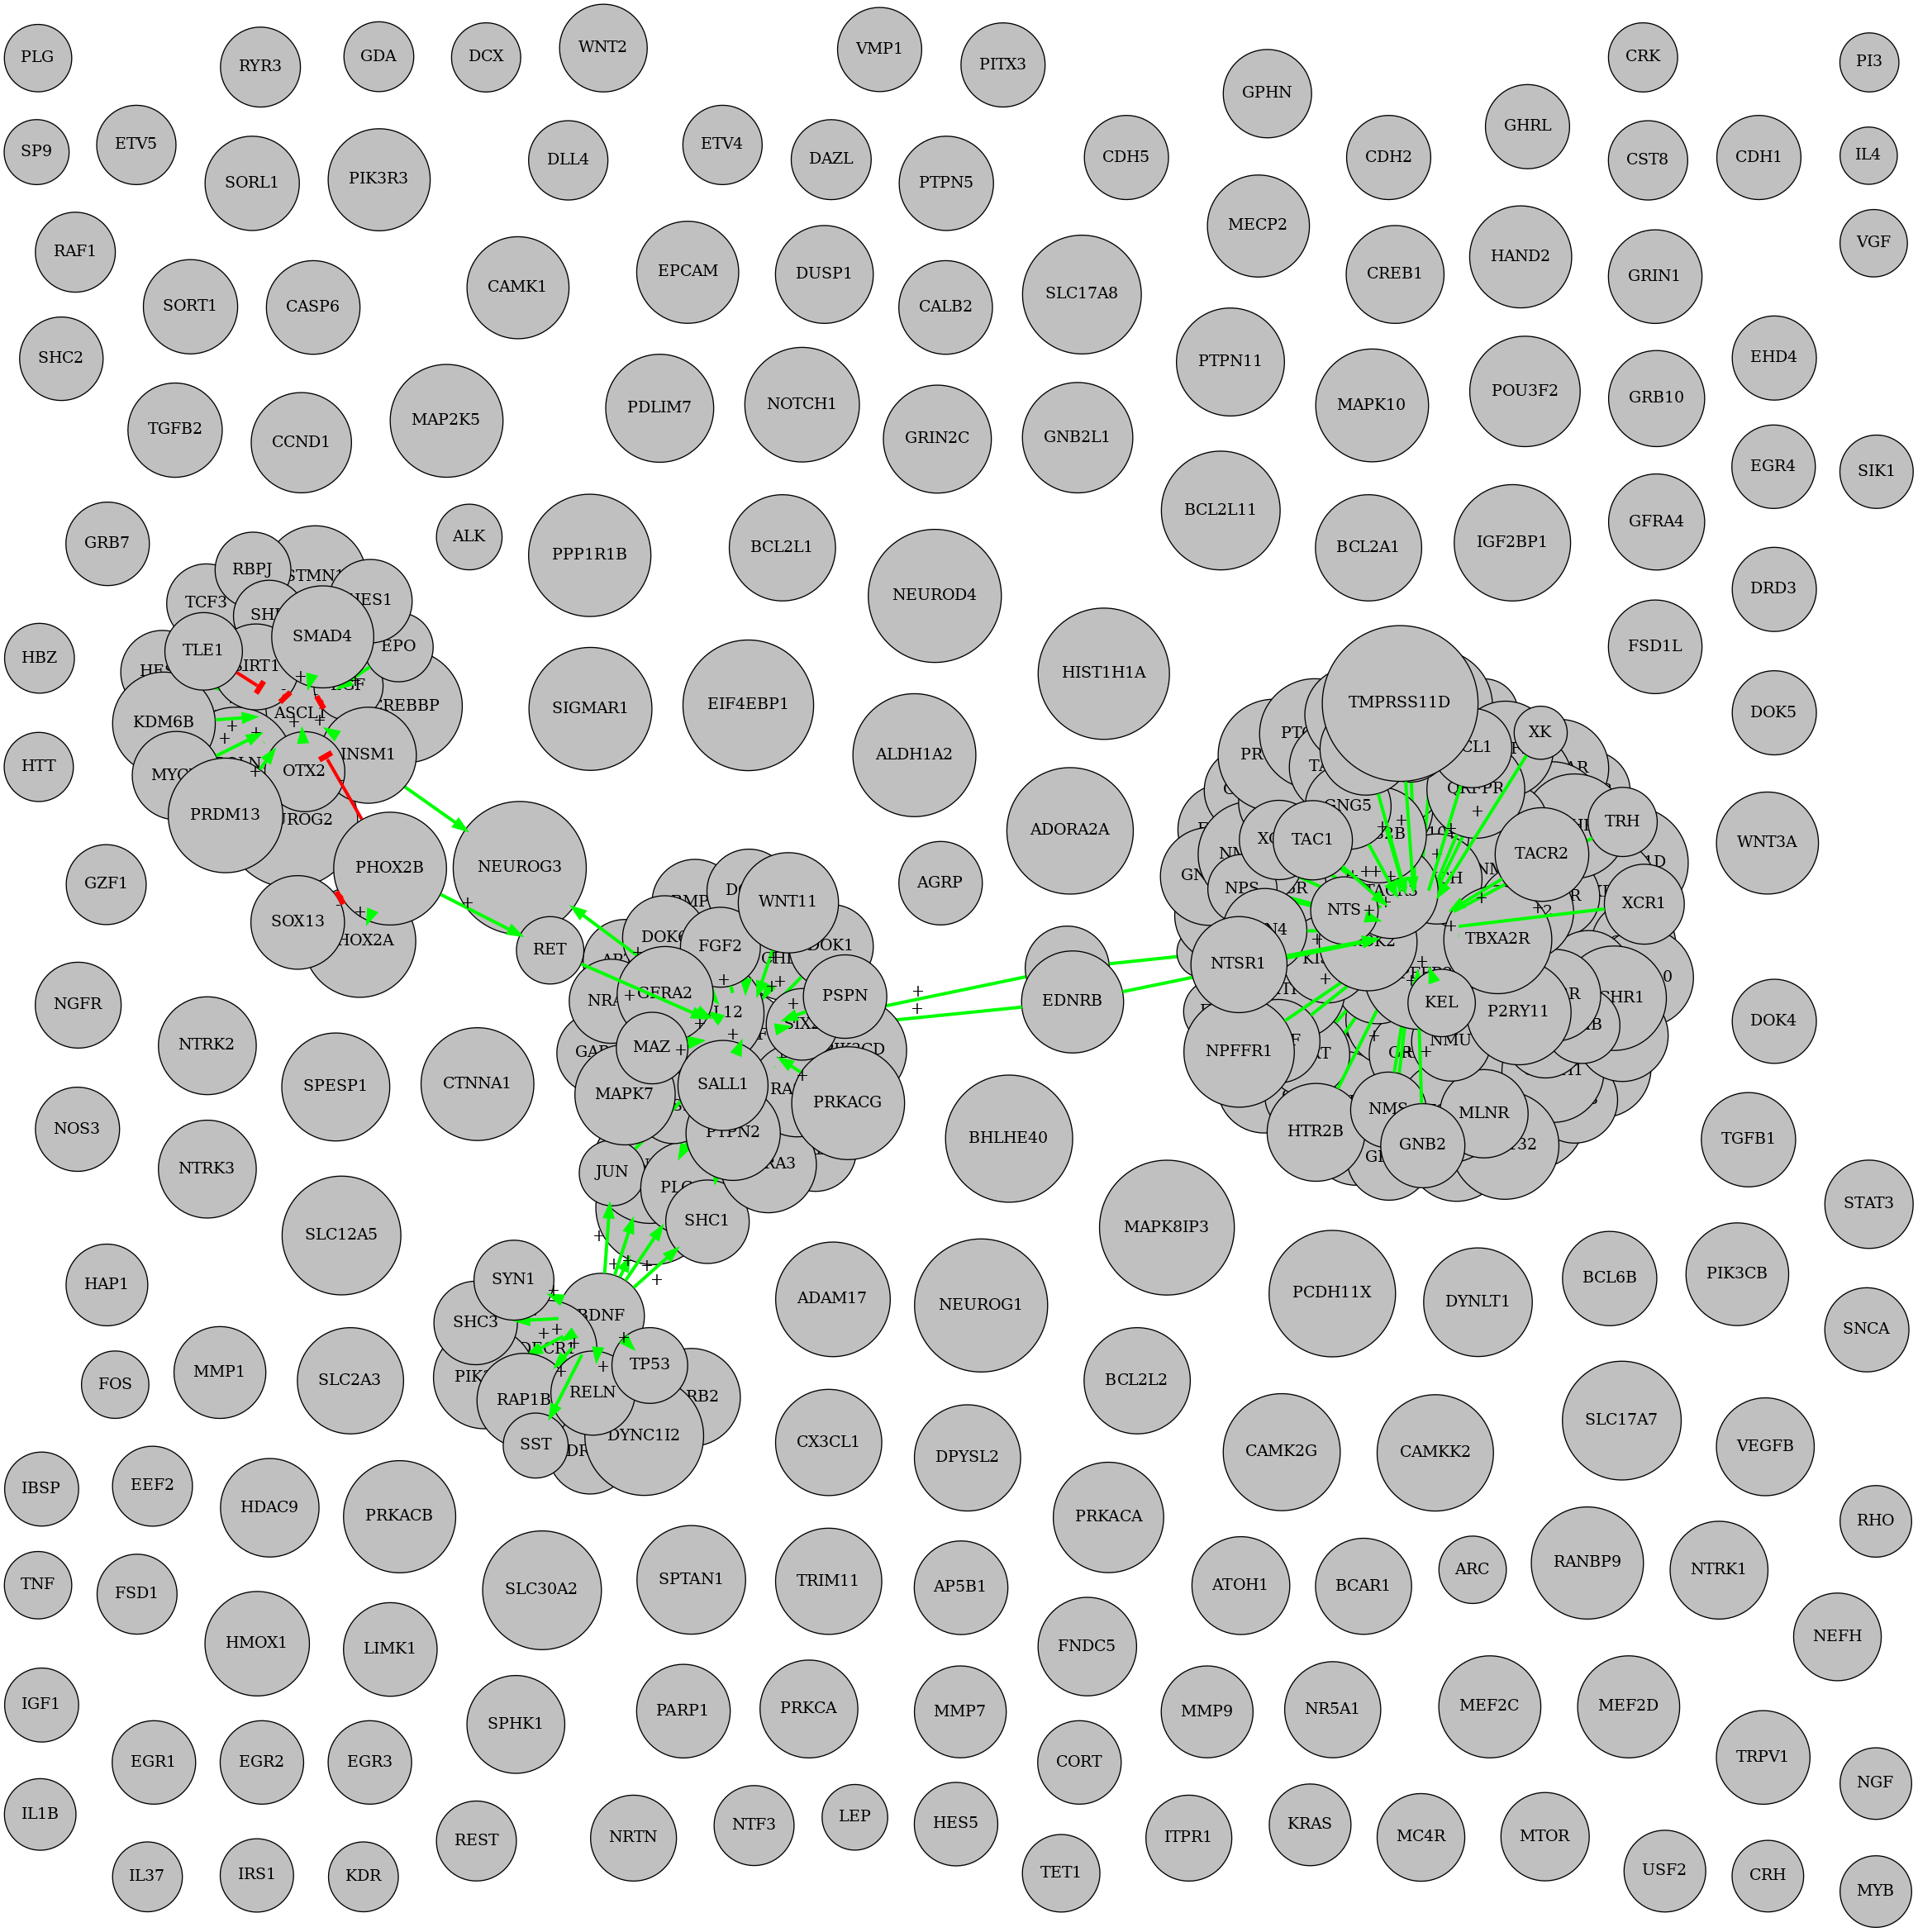

In [10]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

### D. Conclusion

In the next notebook (**Part III**), a network for CCHS will be inferred based on a pre-determined set of genes.